In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [85]:
def generate_data(samples=1000, n_grid=512):
    """
    Generate training and testing data for the function f(x) = 10sin(4x).
    Args:
        samples: Number of sample functions to generate.
        n_grid: Number of grid points on the domain [0, 2*pi].
    Returns:
        x: Grid points on the domain [0, 2*pi].
        y: Function values at the grid points.
    """
    x = np.linspace(0, 2 * np.pi, n_grid, dtype=np.float32)
    y = 10 * np.sin(4 * x)  # Target function f(x) = 10sin(4x)

    # Replicate data for batch dimension
    x = np.tile(x, (samples, 1))  # Shape: (samples, n_grid)
    y = np.tile(y, (samples, 1))  # Shape: (samples, n_grid)

    return torch.tensor(x), torch.tensor(y)

In [67]:
# class FourierLayer1D(nn.Module):
#     def __init__(self, modes, width):
#         super(FourierLayer1D, self).__init__()
#         self.modes = modes
#         self.scale = 1 / (width ** 2)
#         self.weights = nn.Parameter(self.scale * torch.rand(width, width, modes, dtype=torch.cfloat))

#     def forward(self, x):
#         # x: (batch_size, width, n_grid)
#         batchsize, width, n_grid = x.shape
#         x_ft = torch.fft.rfft(x, dim=-1)  # Real FFT

#         out_ft = torch.zeros(batchsize, width, x_ft.shape[-1], device=x.device, dtype=torch.cfloat)
#         out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights)
#         x_out = torch.fft.irfft(out_ft, n=n_grid, dim=-1)
#         return x_out
class FourierLayer1D(nn.Module):
    def __init__(self, modes, width):
        super(FourierLayer1D, self).__init__()
        self.modes = modes
        self.scale = 1 / (width ** 2)
        self.weights = nn.Parameter(self.scale * torch.rand(width, width, modes, dtype=torch.cfloat))

    def forward(self, x):
        # x: (batch_size, width, n_grid)
        batchsize, width, n_grid = x.shape
        x_ft = torch.fft.rfft(x, dim=-1)  # Real FFT

        out_ft = torch.zeros(batchsize, width, x_ft.shape[-1], device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights)
        x_out = torch.fft.irfft(out_ft, n=n_grid, dim=-1)
        return x_out

In [68]:
# Entire Fourier Net 1D from local transformations to global output
# class FNO1D(nn.Module):
#     def __init__(self, modes, width):
#         super(FNO1D, self).__init__()
#         self.modes = modes
#         self.width = width
#         self.fc0 = nn.Linear(2, self.width)  # Input layer (x, y) -> width
        
#         self.fourier_layers = nn.ModuleList([
#             FourierLayer1D(modes, width) for _ in range(4)  # 4 Fourier layers
#         ])
        
#         self.w = nn.ModuleList([
#             nn.Conv1d(self.width, self.width, 1) for _ in range(4)  # Local linear transformations
#         ])
        
#         self.fc1 = nn.Linear(self.width, 128)
#         self.fc2 = nn.Linear(128, 1)  # Output layer

#     def forward(self, x):
#         # x: (batch_size, n_grid, 1)
#         grid = x.unsqueeze(-1)  # Add channel dimension
#         x = torch.cat((x.unsqueeze(-1), grid), dim=-1)  # (batch_size, n_grid, 2)
#         x = self.fc0(x)  # (batch_size, n_grid, width)
#         x = x.permute(0, 2, 1)  # (batch_size, width, n_grid)
        
#         for i in range(4):
#             x1 = self.fourier_layers[i](x)
#             x2 = self.w[i](x)
#             x = F.relu(x1 + x2)
        
#         x = x.permute(0, 2, 1)  # (batch_size, n_grid, width)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)  # (batch_size, n_grid, 1)
#         return x.squeeze(-1)  # Remove last dimension
    
class FNO1D(nn.Module):
    def __init__(self, modes, width):
        super(FNO1D, self).__init__()
        self.modes = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width)  # Input layer (x, y) -> width
        
        self.fourier_layers = nn.ModuleList([
            FourierLayer1D(modes, width) for _ in range(4)  # 4 Fourier layers
        ])
        
        self.w = nn.ModuleList([
            nn.Conv1d(self.width, self.width, 1) for _ in range(4)  # Local linear transformations
        ])
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)  # Output layer

    def forward(self, x):
        # x: (batch_size, n_grid, 1)
        grid = x.unsqueeze(-1)  # Add channel dimension
        x = torch.cat((x.unsqueeze(-1), grid), dim=-1)  # (batch_size, n_grid, 2)
        x = self.fc0(x)  # (batch_size, n_grid, width)
        x = x.permute(0, 2, 1)  # (batch_size, width, n_grid)
        
        for i in range(4):
            x1 = self.fourier_layers[i](x)
            x2 = self.w[i](x)
            x = F.relu(x1 + x2)
        
        x = x.permute(0, 2, 1)  # (batch_size, n_grid, width)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # (batch_size, n_grid, 1)
        return x.squeeze(-1)  # Remove last dimension

In [69]:
# def train_fno(model, dataloader, optimizer, criterion, epochs=100):
#     model.train()
#     for epoch in range(epochs):
#         epoch_loss = 0.0
#         for x_batch, y_batch in dataloader:
#             optimizer.zero_grad()
#             output = model(x_batch)
#             loss = criterion(output, y_batch)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader):.6f}")
def train_fno(model, x_train, y_train, optimizer, criterion, epochs=100):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    return losses

In [70]:
# def test_fno(model, dataloader, criterion):
#     model.eval()
#     test_loss = 0.0
#     all_preds = []
#     with torch.no_grad():
#         for x_batch, y_batch in dataloader:
#             output = model(x_batch)
#             loss = criterion(output, y_batch)
#             test_loss += loss.item()
#             all_preds.append(output)
#     return torch.cat(all_preds, dim=0), test_loss / len(dataloader)
def test_fno(model, x_test, y_test, criterion):
    model.eval()
    with torch.no_grad():
        output = model(x_test)
        loss = criterion(output, y_test)
    return output, loss.item()

EXECUTION

In [72]:
# Generate Data
n_grid = 512
samples = 1000
x, y = generate_data(samples, n_grid)

In [86]:
split_idx = int(0.75 * n_grid)  # 75% for training, 25% for testing
x_train, y_train = x[:, :split_idx], y[:, :split_idx]
x_test, y_test = x[:, split_idx:], y[:, split_idx:]

In [83]:
# Split into train and test sets based on grid points
train_ratio = 0.8
split_idx = int(n_grid * train_ratio)

x_train, y_train = x[:split_idx], y[:split_idx]
x_test, y_test = x[split_idx:], y[split_idx:]

In [87]:
x_train, y_train = x_train.float(), y_train.float()
x_test, y_test = x_test.float(), y_test.float()

In [97]:
x_tot=x.float()
y_tot=y.float()
x_tot.shape, y_tot.shape

(torch.Size([1000, 512]), torch.Size([1000, 512]))

In [100]:
modes = 16
width = 32
model = FNO1D(modes, width)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [101]:
# print("Training the FNO model...")
# losses=train_fno(model, x_train, y_train, optimizer, criterion, epochs=800)
print("Training the FNO model...")
losses = train_fno(model, x_train, y_train, optimizer, criterion, epochs=100)

Training the FNO model...
Epoch 10/100, Loss: 48.906609
Epoch 20/100, Loss: 42.148739
Epoch 30/100, Loss: 11.184289
Epoch 40/100, Loss: 3.354641
Epoch 50/100, Loss: 1.363989
Epoch 60/100, Loss: 0.412192
Epoch 70/100, Loss: 0.135023
Epoch 80/100, Loss: 0.041254
Epoch 90/100, Loss: 0.019998
Epoch 100/100, Loss: 0.013570


In [102]:
print("\nTesting the FNO model...")
pred, test_loss = test_fno(model, x_test, y_test, criterion)
print(f"Test Loss (MSE): {test_loss:.6f}")


Testing the FNO model...
Test Loss (MSE): 59.175121


In [103]:
print("\nTesting the FNO model...")
pred3, test_loss3 = test_fno(model, x_train, y_train, criterion)
print(f"Test Loss (MSE): {test_loss3:.6f}")


Testing the FNO model...
Test Loss (MSE): 0.014056


In [104]:
print("\nTesting the FNO model...")
pred_tot, test_loss_tot = test_fno(model, x_tot, y_tot, criterion)
print(f"Test Loss (MSE): {test_loss_tot:.6f}")


Testing the FNO model...
Test Loss (MSE): 137.464020


In [92]:
rmse = np.sqrt(mean_squared_error(y_test[0].numpy(), pred[0].numpy()))
mape = mean_absolute_percentage_error(y_test[0].numpy(), pred[0].numpy())
r2 = r2_score(y_test[0].numpy(), pred[0].numpy())

print(f"RMSE: {rmse:.6f}")
# print(f"MAPE: {mape:.6f}")
print(f"R2 Score: {r2:.6f}")

RMSE: 7.746714
R2 Score: -0.202579


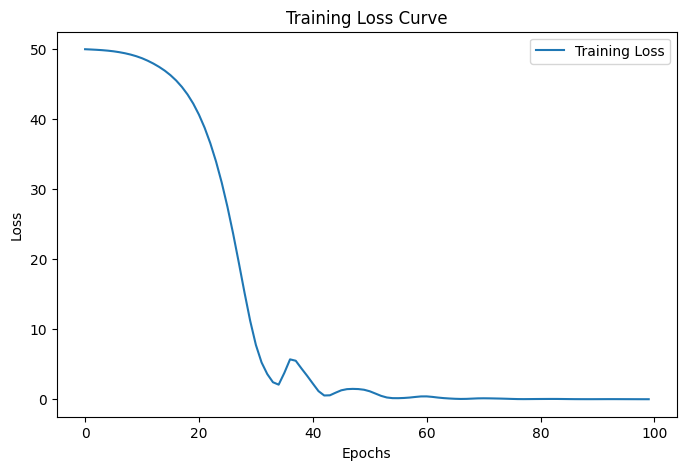

In [105]:
# Plot Training Losses
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

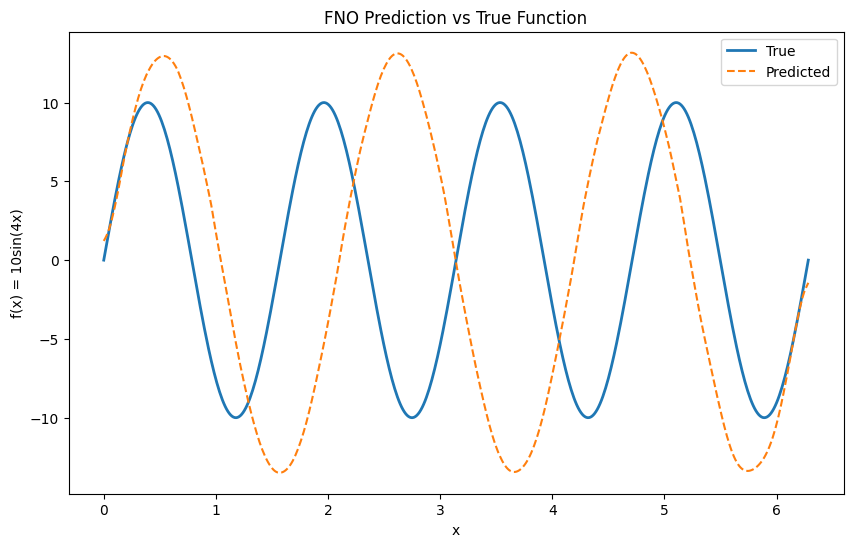

In [106]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(x_tot[0].numpy(), y_tot[0].numpy(), label='True', linewidth=2)
plt.plot(x_tot[0].numpy(), pred_tot[0].numpy(), label='Predicted', linestyle='--')
plt.title('FNO Prediction vs True Function')
plt.xlabel('x')
plt.ylabel('f(x) = 10sin(4x)')
plt.legend()
plt.show()

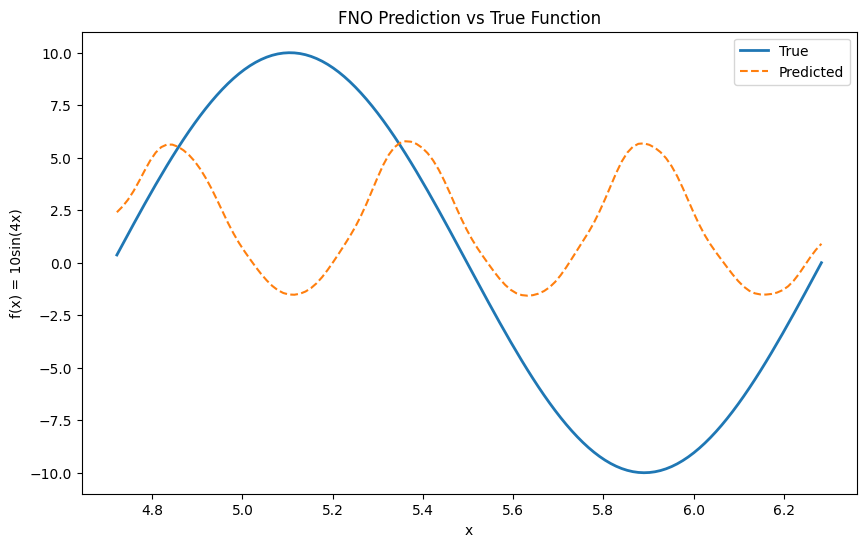

In [107]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(x_test[0].numpy(), y_test[0].numpy(), label='True', linewidth=2)
plt.plot(x_test[0].numpy(), pred[0].numpy(), label='Predicted', linestyle='--')
plt.title('FNO Prediction vs True Function')
plt.xlabel('x')
plt.ylabel('f(x) = 10sin(4x)')
plt.legend()
plt.show()

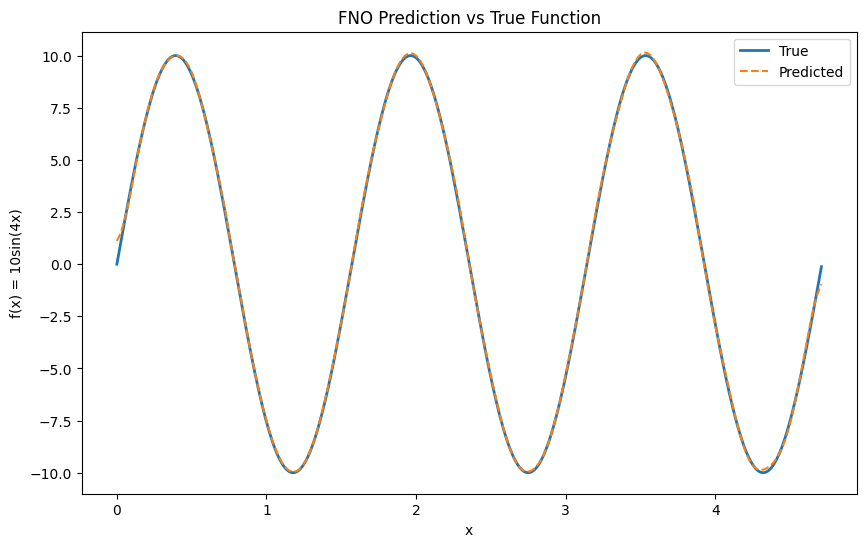

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(x_train[0].numpy(), y_train[0].numpy(), label='True', linewidth=2)
plt.plot(x_train[0].numpy(), pred3[0].numpy(), label='Predicted', linestyle='--')
plt.title('FNO Prediction vs True Function')
plt.xlabel('x')
plt.ylabel('f(x) = 10sin(4x)')
plt.legend()
plt.show()

In [63]:
# Test Model
print("\nTesting the FNO model...")
pred, test_loss = test_fno(model, test_loader, criterion)
print(f"Test Loss (MSE): {test_loss:.6f}")


Testing the FNO model...
Test Loss (MSE): 614.702093


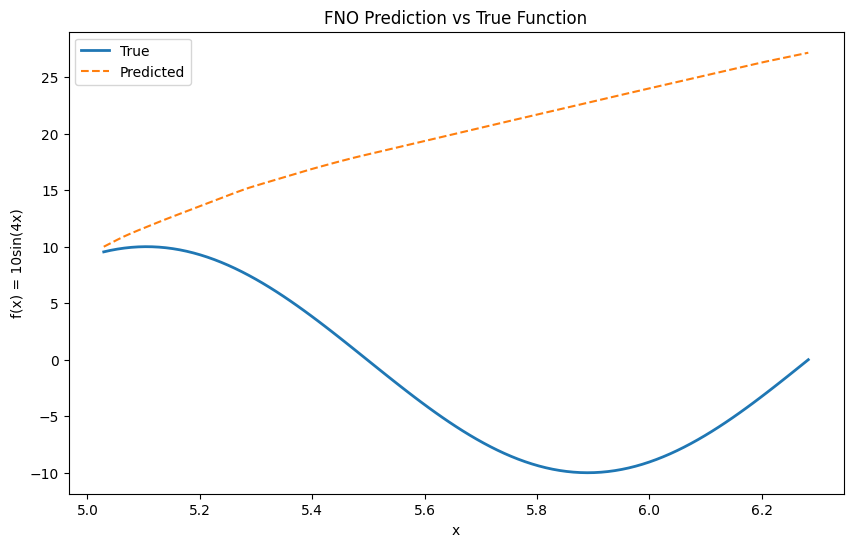

In [64]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(x_test.squeeze(0).numpy(), y_test.squeeze(0).numpy(), label='True', linewidth=2)
plt.plot(x_test.squeeze(0).numpy(), pred.squeeze(0).numpy(), label='Predicted', linestyle='--')
plt.title('FNO Prediction vs True Function')
plt.xlabel('x')
plt.ylabel('f(x) = 10sin(4x)')
plt.legend()
plt.show()

In [20]:
# print("\nTesting the FNO model...")
# pred, test_loss = test_fno(model, x_test, y_test, criterion)
# print(f"Test Loss (MSE): {test_loss:.6f}")

In [21]:
# print("\n testing on entire dataset...on all gridpoints")
# pred2, test_loss2 = test_fno(model, x, y, criterion)
# print(f"Test Loss 2- over entire domain (MSE): {test_loss2:.6f}")

In [22]:
# print("\n testing on training dataset...on all gridpoints")
# pred3, test_loss3 = test_fno(model, x_train, y_train, criterion)
# print(f"Test Loss 3- over training domain (MSE): {test_loss3:.6f}")

In [44]:
rmse = np.sqrt(mean_squared_error(y_test[0].numpy(), pred[0].numpy()))
mape = mean_absolute_percentage_error(y_test[0].numpy(), pred[0].numpy())
r2 = r2_score(y_test[0].numpy(), pred[0].numpy())
print(f"RMSE: {rmse:.6f}")
# print(f"MAPE: {mape:.6f}")
print(f"R2 Score: {r2:.6f}")


RMSE: 7.092581
R2 Score: 0.013462


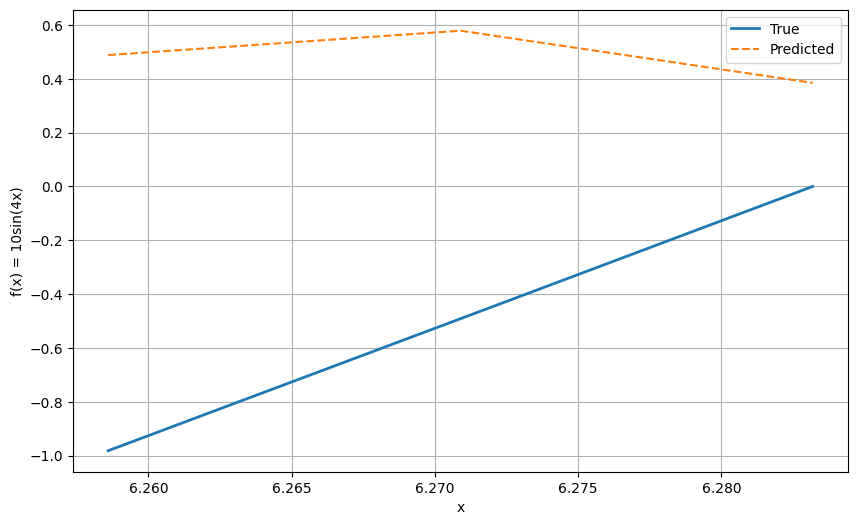

In [48]:
zoom_range = (100, 600)
plt.figure(figsize=(10, 6))
plt.plot(x_test[0, zoom_range[0]:zoom_range[1]].numpy(), 
         y_test[0, zoom_range[0]:zoom_range[1]].numpy(), label='True', linewidth=2)
plt.plot(x_test[0, zoom_range[0]:zoom_range[1]].numpy(), 
         pred[0, zoom_range[0]:zoom_range[1]].numpy(), label='Predicted', linestyle='--')
# plt.title('Zoomed-in FNO Prediction vs True Function')
plt.xlabel('x')
plt.ylabel('f(x) = 10sin(4x)')
plt.grid(True)
plt.legend()
plt.show()